In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
outputFilePath = 'final/lgbm_hyperopt.csv'

In [2]:
# 导入训练集和测试集
test = pd.read_csv('test.csv')
train_nonnull = pd.read_csv('train_nonnull.csv')
train_null = pd.read_csv('train.csv')
train = train_null

In [3]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(train['Gender'])
train['Gender']=le.transform(train['Gender'])

le.fit(train['Region_Code'])
train['Region_Code']=le.transform(train['Region_Code'])

le.fit(train['Channel_Code'])
train['Channel_Code']=le.transform(train['Channel_Code'])

le.fit(train['Credit_Product'])
train['Credit_Product']=le.transform(train['Credit_Product'])

le.fit(train['Is_Active'])
train['Is_Active']=le.transform(train['Is_Active'])

le.fit(train['Occupation'])
train['Occupation']=le.transform(train['Occupation'])

train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,SCVAQHXI,0,29,27,2,0,26,0,302875,0,0
1,BHYZRTQT,0,47,26,3,0,15,0,645552,1,0
2,6STHBLXU,1,44,33,3,2,85,0,725777,1,0
3,KVFKFAM7,1,77,18,1,2,49,0,2297704,1,0
4,RMCZIYYW,0,84,29,1,1,93,0,555199,0,1


In [4]:
#训练集划分
from sklearn.model_selection import train_test_split
from sklearn import metrics
y=train['Is_Lead']
df_train1=train.drop(['Is_Lead','ID',
                      'Region_Code'],axis=1)


x_train_all, x_predict, y_train_all, y_predict = train_test_split(df_train1, y, test_size=0.10, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.1, random_state=42)

import lightgbm as lgb

train_data = lgb.Dataset(data=x_train,label=y_train)
test_data = lgb.Dataset(data=x_test,label=y_test)

In [5]:
#使用lgbm模型开始调参

import lightgbm as lgb
from hyperopt import fmin, tpe, hp, partial
train_data = lgb.Dataset(data=x_train,label=y_train)
test_data = lgb.Dataset(data=x_test,label=y_test)

In [6]:
# 自定义hyperopt的参数空间
space = {"max_depth": hp.randint("max_depth", 15),
         "num_trees": hp.randint("num_trees", 300),
         'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
         "bagging_fraction": hp.randint("bagging_fraction", 5),
         "num_leaves": hp.randint("num_leaves", 6),
         }

def argsDict_tranform(argsDict, isPrint=False):
    argsDict["max_depth"] = argsDict["max_depth"] + 5
    argsDict['num_trees'] = argsDict['num_trees'] + 150
    argsDict["learning_rate"] = argsDict["learning_rate"] * 0.02 + 0.05
    argsDict["bagging_fraction"] = argsDict["bagging_fraction"] * 0.1 + 0.5
    argsDict["num_leaves"] = argsDict["num_leaves"] * 3 + 10
    if isPrint:
        print(argsDict)
    else:
        pass

    return argsDict

In [7]:
def lightgbm_factory(argsDict):
    argsDict = argsDict_tranform(argsDict)
    
    params = {'nthread': -1,  # 进程数
              'max_depth': argsDict['max_depth'],  # 最大深度
              'num_trees': argsDict['num_trees'],  # 树的数量
              'eta': argsDict['learning_rate'],  # 学习率
              'bagging_fraction': argsDict['bagging_fraction'],  # 采样数
              'num_leaves': argsDict['num_leaves'],  # 终点节点最小样本占比的和
              'objective': 'regression',
              'feature_fraction': 0.7,  # 样本列采样
              'lambda_l1': 0,  # L1 正则化
              'lambda_l2': 0,  # L2 正则化
              'bagging_seed': 42,  # 随机种子,light中默认为100
              }
    params['metric'] = ['auc']

    model_lgb = lgb.train(params, train_data, num_boost_round=500, valid_sets=[test_data],early_stopping_rounds=100)

    return get_tranformer_score(model_lgb)

def get_tranformer_score(tranformer):
    
    model = tranformer
    prediction = model.predict(x_predict, num_iteration=model.best_iteration)
    fpr, tpr, threshold = metrics.roc_curve(y_predict, prediction)
    roc_auc = metrics.auc(fpr, tpr)
  
    return roc_auc



In [8]:
# 开始使用hyperopt进行自动调参
algo = partial(tpe.suggest, n_startup_jobs=5)
best = fmin(lightgbm_factory, space, algo=algo, max_evals=50, pass_expr_memo_ctrl=None)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002314 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.858165                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858735                                                                                            
[3]	valid_0's auc: 0.862995           

[63]	valid_0's auc: 0.871124                                                                                           
[64]	valid_0's auc: 0.871162                                                                                           
[65]	valid_0's auc: 0.871169                                                                                           
[66]	valid_0's auc: 0.871193                                                                                           
[67]	valid_0's auc: 0.871156                                                                                           
[68]	valid_0's auc: 0.871402                                                                                           
[69]	valid_0's auc: 0.871411                                                                                           
[70]	valid_0's auc: 0.871458                                                                                           
[71]	valid_0's auc: 0.871452            

[131]	valid_0's auc: 0.871668                                                                                          
[132]	valid_0's auc: 0.871644                                                                                          
[133]	valid_0's auc: 0.871652                                                                                          
[134]	valid_0's auc: 0.871692                                                                                          
[135]	valid_0's auc: 0.871691                                                                                          
[136]	valid_0's auc: 0.871698                                                                                          
[137]	valid_0's auc: 0.871698                                                                                          
[138]	valid_0's auc: 0.871788                                                                                          
[139]	valid_0's auc: 0.871761           

[199]	valid_0's auc: 0.87141                                                                                           
Did not meet early stopping. Best iteration is:                                                                        
[138]	valid_0's auc: 0.871788
  2%|▉                                                | 1/50 [00:02<01:41,  2.06s/trial, best loss: 0.8678898985748134]

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002054 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.856502                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.857836                                                                                            
[3]	valid_0's auc: 0.861537           

[63]	valid_0's auc: 0.870392                                                                                           
[64]	valid_0's auc: 0.870437                                                                                           
[65]	valid_0's auc: 0.870433                                                                                           
[66]	valid_0's auc: 0.870499                                                                                           
[67]	valid_0's auc: 0.870493                                                                                           
[68]	valid_0's auc: 0.87063                                                                                            
[69]	valid_0's auc: 0.87068                                                                                            
[70]	valid_0's auc: 0.87074                                                                                            
[71]	valid_0's auc: 0.870766            

[131]	valid_0's auc: 0.87128                                                                                           
[132]	valid_0's auc: 0.871292                                                                                          
[133]	valid_0's auc: 0.871261                                                                                          
[134]	valid_0's auc: 0.871261                                                                                          
[135]	valid_0's auc: 0.871271                                                                                          
[136]	valid_0's auc: 0.871277                                                                                          
[137]	valid_0's auc: 0.871252                                                                                          
[138]	valid_0's auc: 0.871251                                                                                          
[139]	valid_0's auc: 0.871241           

[199]	valid_0's auc: 0.871035                                                                                          
[200]	valid_0's auc: 0.871028                                                                                          
[201]	valid_0's auc: 0.870975                                                                                          
[202]	valid_0's auc: 0.870977                                                                                          
[203]	valid_0's auc: 0.871003                                                                                          
[204]	valid_0's auc: 0.870989                                                                                          
[205]	valid_0's auc: 0.871057                                                                                          
[206]	valid_0's auc: 0.871036                                                                                          
[207]	valid_0's auc: 0.871              

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002136 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.856502                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.857836                                                                                            
[3]	valid_0's auc: 0.861537           

[63]	valid_0's auc: 0.870496                                                                                           
[64]	valid_0's auc: 0.870532                                                                                           
[65]	valid_0's auc: 0.870552                                                                                           
[66]	valid_0's auc: 0.870633                                                                                           
[67]	valid_0's auc: 0.870659                                                                                           
[68]	valid_0's auc: 0.870718                                                                                           
[69]	valid_0's auc: 0.870733                                                                                           
[70]	valid_0's auc: 0.87064                                                                                            
[71]	valid_0's auc: 0.870642            

[131]	valid_0's auc: 0.871109                                                                                          
[132]	valid_0's auc: 0.871165                                                                                          
[133]	valid_0's auc: 0.871106                                                                                          
[134]	valid_0's auc: 0.871033                                                                                          
[135]	valid_0's auc: 0.871047                                                                                          
[136]	valid_0's auc: 0.87108                                                                                           
[137]	valid_0's auc: 0.871054                                                                                          
[138]	valid_0's auc: 0.871048                                                                                          
[139]	valid_0's auc: 0.871035           

[199]	valid_0's auc: 0.870885                                                                                          
[200]	valid_0's auc: 0.870932                                                                                          
[201]	valid_0's auc: 0.870923                                                                                          
[202]	valid_0's auc: 0.870956                                                                                          
[203]	valid_0's auc: 0.870955                                                                                          
[204]	valid_0's auc: 0.870915                                                                                          
[205]	valid_0's auc: 0.870878                                                                                          
[206]	valid_0's auc: 0.870848                                                                                          
Early stopping, best iteration is:      

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002052 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.860014                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.86413                                                                                             
[3]	valid_0's auc: 0.866002           

[63]	valid_0's auc: 0.871463                                                                                           
[64]	valid_0's auc: 0.871454                                                                                           
[65]	valid_0's auc: 0.871448                                                                                           
[66]	valid_0's auc: 0.871508                                                                                           
[67]	valid_0's auc: 0.871436                                                                                           
[68]	valid_0's auc: 0.871478                                                                                           
[69]	valid_0's auc: 0.871481                                                                                           
[70]	valid_0's auc: 0.871499                                                                                           
[71]	valid_0's auc: 0.871503            

[131]	valid_0's auc: 0.871482                                                                                          
[132]	valid_0's auc: 0.871461                                                                                          
[133]	valid_0's auc: 0.871427                                                                                          
[134]	valid_0's auc: 0.871423                                                                                          
[135]	valid_0's auc: 0.871409                                                                                          
[136]	valid_0's auc: 0.871448                                                                                          
[137]	valid_0's auc: 0.871392                                                                                          
[138]	valid_0's auc: 0.871391                                                                                          
[139]	valid_0's auc: 0.871364           

[199]	valid_0's auc: 0.871281                                                                                          
[200]	valid_0's auc: 0.871264                                                                                          
[201]	valid_0's auc: 0.871232                                                                                          
[202]	valid_0's auc: 0.871166                                                                                          
[203]	valid_0's auc: 0.871176                                                                                          
[204]	valid_0's auc: 0.871186                                                                                          
[205]	valid_0's auc: 0.871198                                                                                          
[206]	valid_0's auc: 0.87126                                                                                           
[207]	valid_0's auc: 0.871278           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859859                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.864181                                                                                            
[3]	valid_0's auc: 0.865248           

[63]	valid_0's auc: 0.87151                                                                                            
[64]	valid_0's auc: 0.87157                                                                                            
[65]	valid_0's auc: 0.871565                                                                                           
[66]	valid_0's auc: 0.871633                                                                                           
[67]	valid_0's auc: 0.87165                                                                                            
[68]	valid_0's auc: 0.871671                                                                                           
[69]	valid_0's auc: 0.871576                                                                                           
[70]	valid_0's auc: 0.871574                                                                                           
[71]	valid_0's auc: 0.871634            

[131]	valid_0's auc: 0.871905                                                                                          
[132]	valid_0's auc: 0.871846                                                                                          
[133]	valid_0's auc: 0.871892                                                                                          
[134]	valid_0's auc: 0.871896                                                                                          
[135]	valid_0's auc: 0.871899                                                                                          
[136]	valid_0's auc: 0.871915                                                                                          
[137]	valid_0's auc: 0.871927                                                                                          
[138]	valid_0's auc: 0.872032                                                                                          
[139]	valid_0's auc: 0.872022           

[199]	valid_0's auc: 0.871453                                                                                          
[200]	valid_0's auc: 0.871449                                                                                          
[201]	valid_0's auc: 0.871412                                                                                          
[202]	valid_0's auc: 0.871379                                                                                          
[203]	valid_0's auc: 0.871328                                                                                          
[204]	valid_0's auc: 0.871313                                                                                          
[205]	valid_0's auc: 0.87132                                                                                           
[206]	valid_0's auc: 0.871299                                                                                          
[207]	valid_0's auc: 0.871319           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.862879                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.863741                                                                                            
[3]	valid_0's auc: 0.86502            

[63]	valid_0's auc: 0.871021                                                                                           
[64]	valid_0's auc: 0.871045                                                                                           
[65]	valid_0's auc: 0.871074                                                                                           
[66]	valid_0's auc: 0.871116                                                                                           
[67]	valid_0's auc: 0.871131                                                                                           
[68]	valid_0's auc: 0.871148                                                                                           
[69]	valid_0's auc: 0.871114                                                                                           
[70]	valid_0's auc: 0.871112                                                                                           
[71]	valid_0's auc: 0.871143            

[131]	valid_0's auc: 0.871                                                                                             
[132]	valid_0's auc: 0.871006                                                                                          
[133]	valid_0's auc: 0.871038                                                                                          
[134]	valid_0's auc: 0.87104                                                                                           
[135]	valid_0's auc: 0.871067                                                                                          
[136]	valid_0's auc: 0.871054                                                                                          
[137]	valid_0's auc: 0.871038                                                                                          
[138]	valid_0's auc: 0.871056                                                                                          
[139]	valid_0's auc: 0.871067           

[198]	valid_0's auc: 0.871109                                                                                          
[199]	valid_0's auc: 0.871141                                                                                          
[200]	valid_0's auc: 0.871131                                                                                          
[201]	valid_0's auc: 0.871123                                                                                          
[202]	valid_0's auc: 0.871085                                                                                          
[203]	valid_0's auc: 0.871039                                                                                          
[204]	valid_0's auc: 0.87107                                                                                           
Early stopping, best iteration is:                                                                                     
[104]	valid_0's auc: 0.871385
 12%|█████

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003159 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859409                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.863119                                                                                            
[3]	valid_0's auc: 0.865075           

[63]	valid_0's auc: 0.871317                                                                                           
[64]	valid_0's auc: 0.87138                                                                                            
[65]	valid_0's auc: 0.8714                                                                                             
[66]	valid_0's auc: 0.871413                                                                                           
[67]	valid_0's auc: 0.871425                                                                                           
[68]	valid_0's auc: 0.871472                                                                                           
[69]	valid_0's auc: 0.871468                                                                                           
[70]	valid_0's auc: 0.87142                                                                                            
[71]	valid_0's auc: 0.871411            

[131]	valid_0's auc: 0.87125                                                                                           
[132]	valid_0's auc: 0.871198                                                                                          
[133]	valid_0's auc: 0.871362                                                                                          
[134]	valid_0's auc: 0.871335                                                                                          
[135]	valid_0's auc: 0.871419                                                                                          
[136]	valid_0's auc: 0.87139                                                                                           
[137]	valid_0's auc: 0.871395                                                                                          
[138]	valid_0's auc: 0.871388                                                                                          
[139]	valid_0's auc: 0.871386           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002218 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859571                                                                                            
[3]	valid_0's auc: 0.863931           

[63]	valid_0's auc: 0.871135                                                                                           
[64]	valid_0's auc: 0.87117                                                                                            
[65]	valid_0's auc: 0.871215                                                                                           
[66]	valid_0's auc: 0.871344                                                                                           
[67]	valid_0's auc: 0.871371                                                                                           
[68]	valid_0's auc: 0.871429                                                                                           
[69]	valid_0's auc: 0.871485                                                                                           
[70]	valid_0's auc: 0.871492                                                                                           
[71]	valid_0's auc: 0.871508            

[131]	valid_0's auc: 0.871758                                                                                          
[132]	valid_0's auc: 0.871753                                                                                          
[133]	valid_0's auc: 0.871765                                                                                          
[134]	valid_0's auc: 0.871748                                                                                          
[135]	valid_0's auc: 0.871659                                                                                          
[136]	valid_0's auc: 0.871652                                                                                          
[137]	valid_0's auc: 0.871694                                                                                          
[138]	valid_0's auc: 0.871692                                                                                          
[139]	valid_0's auc: 0.871615           

[199]	valid_0's auc: 0.871304                                                                                          
[200]	valid_0's auc: 0.871316                                                                                          
[201]	valid_0's auc: 0.871309                                                                                          
[202]	valid_0's auc: 0.871324                                                                                          
Did not meet early stopping. Best iteration is:                                                                        
[128]	valid_0's auc: 0.871778
 16%|███████▊                                         | 8/50 [00:16<01:27,  2.09s/trial, best loss: 0.8671549148216926]

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.85489                                                                                             
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.855817                                                                                            
[3]	valid_0's auc: 0.859763           

[63]	valid_0's auc: 0.87009                                                                                            
[64]	valid_0's auc: 0.870168                                                                                           
[65]	valid_0's auc: 0.870194                                                                                           
[66]	valid_0's auc: 0.870324                                                                                           
[67]	valid_0's auc: 0.870386                                                                                           
[68]	valid_0's auc: 0.87045                                                                                            
[69]	valid_0's auc: 0.870596                                                                                           
[70]	valid_0's auc: 0.87065                                                                                            
[71]	valid_0's auc: 0.870626            

[131]	valid_0's auc: 0.871096                                                                                          
[132]	valid_0's auc: 0.871072                                                                                          
[133]	valid_0's auc: 0.871093                                                                                          
[134]	valid_0's auc: 0.871064                                                                                          
[135]	valid_0's auc: 0.871071                                                                                          
[136]	valid_0's auc: 0.871131                                                                                          
[137]	valid_0's auc: 0.871093                                                                                          
[138]	valid_0's auc: 0.871086                                                                                          
[139]	valid_0's auc: 0.871128           

[199]	valid_0's auc: 0.870746                                                                                          
[200]	valid_0's auc: 0.870752                                                                                          
[201]	valid_0's auc: 0.870701                                                                                          
[202]	valid_0's auc: 0.870721                                                                                          
[203]	valid_0's auc: 0.870736                                                                                          
[204]	valid_0's auc: 0.870707                                                                                          
[205]	valid_0's auc: 0.870777                                                                                          
[206]	valid_0's auc: 0.870788                                                                                          
[207]	valid_0's auc: 0.870764           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002683 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859859                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.86417                                                                                             
[3]	valid_0's auc: 0.865199           

[63]	valid_0's auc: 0.871802                                                                                           
[64]	valid_0's auc: 0.871785                                                                                           
[65]	valid_0's auc: 0.871792                                                                                           
[66]	valid_0's auc: 0.871809                                                                                           
[67]	valid_0's auc: 0.871712                                                                                           
[68]	valid_0's auc: 0.871727                                                                                           
[69]	valid_0's auc: 0.871739                                                                                           
[70]	valid_0's auc: 0.871744                                                                                           
[71]	valid_0's auc: 0.87178             

[131]	valid_0's auc: 0.871828                                                                                          
[132]	valid_0's auc: 0.871844                                                                                          
[133]	valid_0's auc: 0.871848                                                                                          
[134]	valid_0's auc: 0.871866                                                                                          
[135]	valid_0's auc: 0.871884                                                                                          
[136]	valid_0's auc: 0.871827                                                                                          
[137]	valid_0's auc: 0.871829                                                                                          
[138]	valid_0's auc: 0.871833                                                                                          
[139]	valid_0's auc: 0.871786           

[199]	valid_0's auc: 0.871504                                                                                          
[200]	valid_0's auc: 0.871505                                                                                          
[201]	valid_0's auc: 0.871506                                                                                          
[202]	valid_0's auc: 0.871466                                                                                          
[203]	valid_0's auc: 0.871465                                                                                          
[204]	valid_0's auc: 0.871462                                                                                          
[205]	valid_0's auc: 0.871406                                                                                          
[206]	valid_0's auc: 0.871455                                                                                          
[207]	valid_0's auc: 0.871482           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002282 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859859                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.86417                                                                                             
[3]	valid_0's auc: 0.865199           

[63]	valid_0's auc: 0.871715                                                                                           
[64]	valid_0's auc: 0.871714                                                                                           
[65]	valid_0's auc: 0.871722                                                                                           
[66]	valid_0's auc: 0.871775                                                                                           
[67]	valid_0's auc: 0.871754                                                                                           
[68]	valid_0's auc: 0.871781                                                                                           
[69]	valid_0's auc: 0.871792                                                                                           
[70]	valid_0's auc: 0.871792                                                                                           
[71]	valid_0's auc: 0.871812            

[131]	valid_0's auc: 0.872135                                                                                          
[132]	valid_0's auc: 0.872131                                                                                          
[133]	valid_0's auc: 0.872154                                                                                          
[134]	valid_0's auc: 0.872138                                                                                          
[135]	valid_0's auc: 0.87213                                                                                           
[136]	valid_0's auc: 0.872045                                                                                          
[137]	valid_0's auc: 0.872032                                                                                          
[138]	valid_0's auc: 0.872037                                                                                          
[139]	valid_0's auc: 0.872047           

[199]	valid_0's auc: 0.871996                                                                                          
[200]	valid_0's auc: 0.871986                                                                                          
[201]	valid_0's auc: 0.872018                                                                                          
[202]	valid_0's auc: 0.872035                                                                                          
[203]	valid_0's auc: 0.872006                                                                                          
[204]	valid_0's auc: 0.871998                                                                                          
[205]	valid_0's auc: 0.871988                                                                                          
[206]	valid_0's auc: 0.871974                                                                                          
[207]	valid_0's auc: 0.871964           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859483                                                                                            
[3]	valid_0's auc: 0.863916           

[63]	valid_0's auc: 0.871079                                                                                           
[64]	valid_0's auc: 0.871108                                                                                           
[65]	valid_0's auc: 0.871137                                                                                           
[66]	valid_0's auc: 0.871241                                                                                           
[67]	valid_0's auc: 0.871354                                                                                           
[68]	valid_0's auc: 0.871441                                                                                           
[69]	valid_0's auc: 0.871416                                                                                           
[70]	valid_0's auc: 0.871359                                                                                           
[71]	valid_0's auc: 0.871334            

[131]	valid_0's auc: 0.871687                                                                                          
[132]	valid_0's auc: 0.87168                                                                                           
[133]	valid_0's auc: 0.871681                                                                                          
[134]	valid_0's auc: 0.871627                                                                                          
[135]	valid_0's auc: 0.871629                                                                                          
[136]	valid_0's auc: 0.87162                                                                                           
[137]	valid_0's auc: 0.871627                                                                                          
[138]	valid_0's auc: 0.871613                                                                                          
[139]	valid_0's auc: 0.87159            

[199]	valid_0's auc: 0.87171                                                                                           
[200]	valid_0's auc: 0.871727                                                                                          
[201]	valid_0's auc: 0.871758                                                                                          
[202]	valid_0's auc: 0.871757                                                                                          
[203]	valid_0's auc: 0.871753                                                                                          
[204]	valid_0's auc: 0.871761                                                                                          
[205]	valid_0's auc: 0.871767                                                                                          
[206]	valid_0's auc: 0.871762                                                                                          
[207]	valid_0's auc: 0.871761           

[267]	valid_0's auc: 0.871544                                                                                          
[268]	valid_0's auc: 0.871564                                                                                          
[269]	valid_0's auc: 0.871545                                                                                          
[270]	valid_0's auc: 0.871507                                                                                          
[271]	valid_0's auc: 0.871505                                                                                          
[272]	valid_0's auc: 0.871456                                                                                          
[273]	valid_0's auc: 0.871448                                                                                          
[274]	valid_0's auc: 0.871348                                                                                          
[275]	valid_0's auc: 0.871309           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001953 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859483                                                                                            
[3]	valid_0's auc: 0.863916           

[63]	valid_0's auc: 0.871014                                                                                           
[64]	valid_0's auc: 0.871064                                                                                           
[65]	valid_0's auc: 0.871024                                                                                           
[66]	valid_0's auc: 0.871044                                                                                           
[67]	valid_0's auc: 0.871078                                                                                           
[68]	valid_0's auc: 0.87115                                                                                            
[69]	valid_0's auc: 0.871152                                                                                           
[70]	valid_0's auc: 0.871165                                                                                           
[71]	valid_0's auc: 0.871132            

[131]	valid_0's auc: 0.871517                                                                                          
[132]	valid_0's auc: 0.871508                                                                                          
[133]	valid_0's auc: 0.871502                                                                                          
[134]	valid_0's auc: 0.871503                                                                                          
[135]	valid_0's auc: 0.871508                                                                                          
[136]	valid_0's auc: 0.871526                                                                                          
[137]	valid_0's auc: 0.87152                                                                                           
[138]	valid_0's auc: 0.871524                                                                                          
[139]	valid_0's auc: 0.871518           

[199]	valid_0's auc: 0.871351                                                                                          
[200]	valid_0's auc: 0.871353                                                                                          
[201]	valid_0's auc: 0.871369                                                                                          
[202]	valid_0's auc: 0.871352                                                                                          
[203]	valid_0's auc: 0.871399                                                                                          
[204]	valid_0's auc: 0.871382                                                                                          
[205]	valid_0's auc: 0.871357                                                                                          
[206]	valid_0's auc: 0.871346                                                                                          
[207]	valid_0's auc: 0.871354           

[267]	valid_0's auc: 0.871147                                                                                          
[268]	valid_0's auc: 0.871141                                                                                          
[269]	valid_0's auc: 0.871121                                                                                          
[270]	valid_0's auc: 0.871128                                                                                          
[271]	valid_0's auc: 0.871109                                                                                          
[272]	valid_0's auc: 0.87111                                                                                           
[273]	valid_0's auc: 0.871105                                                                                          
[274]	valid_0's auc: 0.871066                                                                                          
[275]	valid_0's auc: 0.871079           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859571                                                                                            
[3]	valid_0's auc: 0.86393            

[63]	valid_0's auc: 0.870978                                                                                           
[64]	valid_0's auc: 0.871065                                                                                           
[65]	valid_0's auc: 0.871095                                                                                           
[66]	valid_0's auc: 0.871153                                                                                           
[67]	valid_0's auc: 0.871231                                                                                           
[68]	valid_0's auc: 0.871371                                                                                           
[69]	valid_0's auc: 0.871351                                                                                           
[70]	valid_0's auc: 0.871349                                                                                           
[71]	valid_0's auc: 0.871292            

[131]	valid_0's auc: 0.871564                                                                                          
[132]	valid_0's auc: 0.871535                                                                                          
[133]	valid_0's auc: 0.871533                                                                                          
[134]	valid_0's auc: 0.87153                                                                                           
[135]	valid_0's auc: 0.871537                                                                                          
[136]	valid_0's auc: 0.871453                                                                                          
[137]	valid_0's auc: 0.871462                                                                                          
[138]	valid_0's auc: 0.871568                                                                                          
[139]	valid_0's auc: 0.871564           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.858165                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858735                                                                                            
[3]	valid_0's auc: 0.86299            

[63]	valid_0's auc: 0.870917                                                                                           
[64]	valid_0's auc: 0.870871                                                                                           
[65]	valid_0's auc: 0.87089                                                                                            
[66]	valid_0's auc: 0.870897                                                                                           
[67]	valid_0's auc: 0.870938                                                                                           
[68]	valid_0's auc: 0.870974                                                                                           
[69]	valid_0's auc: 0.870977                                                                                           
[70]	valid_0's auc: 0.871008                                                                                           
[71]	valid_0's auc: 0.870993            

[131]	valid_0's auc: 0.871319                                                                                          
[132]	valid_0's auc: 0.871329                                                                                          
[133]	valid_0's auc: 0.871337                                                                                          
[134]	valid_0's auc: 0.871339                                                                                          
[135]	valid_0's auc: 0.871329                                                                                          
[136]	valid_0's auc: 0.871323                                                                                          
[137]	valid_0's auc: 0.871317                                                                                          
[138]	valid_0's auc: 0.87134                                                                                           
[139]	valid_0's auc: 0.871344           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002361 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859571                                                                                            
[3]	valid_0's auc: 0.863917           

[63]	valid_0's auc: 0.871204                                                                                           
[64]	valid_0's auc: 0.87121                                                                                            
[65]	valid_0's auc: 0.871279                                                                                           
[66]	valid_0's auc: 0.871358                                                                                           
[67]	valid_0's auc: 0.871448                                                                                           
[68]	valid_0's auc: 0.871492                                                                                           
[69]	valid_0's auc: 0.871492                                                                                           
[70]	valid_0's auc: 0.87149                                                                                            
[71]	valid_0's auc: 0.871493            

[131]	valid_0's auc: 0.871819                                                                                          
[132]	valid_0's auc: 0.871843                                                                                          
[133]	valid_0's auc: 0.871801                                                                                          
[134]	valid_0's auc: 0.871805                                                                                          
[135]	valid_0's auc: 0.871821                                                                                          
[136]	valid_0's auc: 0.871842                                                                                          
[137]	valid_0's auc: 0.871839                                                                                          
[138]	valid_0's auc: 0.871851                                                                                          
[139]	valid_0's auc: 0.871851           

[199]	valid_0's auc: 0.871889                                                                                          
[200]	valid_0's auc: 0.871906                                                                                          
[201]	valid_0's auc: 0.8719                                                                                            
[202]	valid_0's auc: 0.871876                                                                                          
[203]	valid_0's auc: 0.871875                                                                                          
[204]	valid_0's auc: 0.871897                                                                                          
[205]	valid_0's auc: 0.871911                                                                                          
[206]	valid_0's auc: 0.871886                                                                                          
[207]	valid_0's auc: 0.871791           

Early stopping, best iteration is:                                                                                     
[166]	valid_0's auc: 0.872106
 32%|███████████████▎                                | 16/50 [00:36<01:24,  2.47s/trial, best loss: 0.8670748950620109]

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002302 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.85489                                                                                             
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.855817                                                                                            
[3]	valid_0's auc: 0.859756           

[63]	valid_0's auc: 0.869688                                                                                           
[64]	valid_0's auc: 0.869806                                                                                           
[65]	valid_0's auc: 0.86988                                                                                            
[66]	valid_0's auc: 0.869942                                                                                           
[67]	valid_0's auc: 0.869986                                                                                           
[68]	valid_0's auc: 0.870013                                                                                           
[69]	valid_0's auc: 0.870044                                                                                           
[70]	valid_0's auc: 0.869978                                                                                           
[71]	valid_0's auc: 0.870025            

[131]	valid_0's auc: 0.871139                                                                                          
[132]	valid_0's auc: 0.871178                                                                                          
[133]	valid_0's auc: 0.871192                                                                                          
[134]	valid_0's auc: 0.871213                                                                                          
[135]	valid_0's auc: 0.87121                                                                                           
[136]	valid_0's auc: 0.871197                                                                                          
[137]	valid_0's auc: 0.871256                                                                                          
[138]	valid_0's auc: 0.87127                                                                                           
[139]	valid_0's auc: 0.871254           

[199]	valid_0's auc: 0.870874                                                                                          
[200]	valid_0's auc: 0.870883                                                                                          
[201]	valid_0's auc: 0.870899                                                                                          
[202]	valid_0's auc: 0.870876                                                                                          
[203]	valid_0's auc: 0.870863                                                                                          
[204]	valid_0's auc: 0.870867                                                                                          
[205]	valid_0's auc: 0.870841                                                                                          
[206]	valid_0's auc: 0.870861                                                                                          
[207]	valid_0's auc: 0.870856           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859443                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.860025                                                                                            
[3]	valid_0's auc: 0.864888           

[63]	valid_0's auc: 0.871444                                                                                           
[64]	valid_0's auc: 0.871463                                                                                           
[65]	valid_0's auc: 0.871501                                                                                           
[66]	valid_0's auc: 0.871494                                                                                           
[67]	valid_0's auc: 0.871514                                                                                           
[68]	valid_0's auc: 0.87154                                                                                            
[69]	valid_0's auc: 0.871579                                                                                           
[70]	valid_0's auc: 0.871608                                                                                           
[71]	valid_0's auc: 0.87155             

[131]	valid_0's auc: 0.871398                                                                                          
[132]	valid_0's auc: 0.871403                                                                                          
[133]	valid_0's auc: 0.871456                                                                                          
[134]	valid_0's auc: 0.871451                                                                                          
[135]	valid_0's auc: 0.871461                                                                                          
[136]	valid_0's auc: 0.87146                                                                                           
[137]	valid_0's auc: 0.871463                                                                                          
[138]	valid_0's auc: 0.871467                                                                                          
[139]	valid_0's auc: 0.871396           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002667 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.861223                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.862023                                                                                            
[3]	valid_0's auc: 0.862765           

[63]	valid_0's auc: 0.870596                                                                                           
[64]	valid_0's auc: 0.870732                                                                                           
[65]	valid_0's auc: 0.870768                                                                                           
[66]	valid_0's auc: 0.870817                                                                                           
[67]	valid_0's auc: 0.870861                                                                                           
[68]	valid_0's auc: 0.870889                                                                                           
[69]	valid_0's auc: 0.870974                                                                                           
[70]	valid_0's auc: 0.870981                                                                                           
[71]	valid_0's auc: 0.87097             

[122]	valid_0's auc: 0.871052                                                                                          
[123]	valid_0's auc: 0.871045                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[124]	valid_0's auc: 0.871044                                                                                          
[125]	valid_0's auc: 0.871019                                                                                          
[126]	valid_0's auc: 0.870994                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[127]	valid_0's auc: 0.870977                                                                                          
[128]	valid_0's auc: 0.871014           

[180]	valid_0's auc: 0.870895                                                                                          
[181]	valid_0's auc: 0.870906                                                                                          
[182]	valid_0's auc: 0.870888                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[183]	valid_0's auc: 0.870832                                                                                          
[184]	valid_0's auc: 0.870827                                                                                          
[185]	valid_0's auc: 0.870843                                                                                          
[186]	valid_0's auc: 0.870795                                                                                          
[LightGBM] [Warning] No further splits w

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002514 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.861078                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.862068                                                                                            
[3]	valid_0's auc: 0.862858           

[63]	valid_0's auc: 0.870586                                                                                           
[64]	valid_0's auc: 0.870615                                                                                           
[65]	valid_0's auc: 0.870663                                                                                           
[66]	valid_0's auc: 0.870603                                                                                           
[67]	valid_0's auc: 0.870697                                                                                           
[68]	valid_0's auc: 0.87073                                                                                            
[69]	valid_0's auc: 0.870796                                                                                           
[70]	valid_0's auc: 0.870817                                                                                           
[71]	valid_0's auc: 0.870793            

[127]	valid_0's auc: 0.871242                                                                                          
[128]	valid_0's auc: 0.871236                                                                                          
[129]	valid_0's auc: 0.871216                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[130]	valid_0's auc: 0.871239                                                                                          
[131]	valid_0's auc: 0.871231                                                                                          
[132]	valid_0's auc: 0.871236                                                                                          
[133]	valid_0's auc: 0.871255                                                                                          
[134]	valid_0's auc: 0.871266           

[188]	valid_0's auc: 0.870518                                                                                          
[189]	valid_0's auc: 0.870519                                                                                          
[190]	valid_0's auc: 0.870515                                                                                          
[191]	valid_0's auc: 0.870526                                                                                          
[192]	valid_0's auc: 0.870546                                                                                          
[193]	valid_0's auc: 0.870542                                                                                          
[194]	valid_0's auc: 0.870542                                                                                          
[195]	valid_0's auc: 0.870537                                                                                          
[196]	valid_0's auc: 0.870547           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002460 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.861078                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.862068                                                                                            
[3]	valid_0's auc: 0.862864           

[63]	valid_0's auc: 0.870529                                                                                           
[64]	valid_0's auc: 0.870542                                                                                           
[65]	valid_0's auc: 0.870558                                                                                           
[66]	valid_0's auc: 0.870611                                                                                           
[67]	valid_0's auc: 0.870666                                                                                           
[68]	valid_0's auc: 0.870678                                                                                           
[69]	valid_0's auc: 0.870778                                                                                           
[70]	valid_0's auc: 0.870806                                                                                           
[71]	valid_0's auc: 0.870859            

[125]	valid_0's auc: 0.871262                                                                                          
[126]	valid_0's auc: 0.871231                                                                                          
[127]	valid_0's auc: 0.871179                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[128]	valid_0's auc: 0.871182                                                                                          
[129]	valid_0's auc: 0.871138                                                                                          
[130]	valid_0's auc: 0.871131                                                                                          
[131]	valid_0's auc: 0.871112                                                                                          
[132]	valid_0's auc: 0.871117           

[188]	valid_0's auc: 0.870767                                                                                          
[189]	valid_0's auc: 0.870799                                                                                          
[190]	valid_0's auc: 0.870791                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[191]	valid_0's auc: 0.870799                                                                                          
[192]	valid_0's auc: 0.870783                                                                                          
[193]	valid_0's auc: 0.87074                                                                                           
[194]	valid_0's auc: 0.870711                                                                                          
[195]	valid_0's auc: 0.870708           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002927 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.860756                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.861712                                                                                            
[3]	valid_0's auc: 0.862811           

[63]	valid_0's auc: 0.87053                                                                                            
[64]	valid_0's auc: 0.870544                                                                                           
[65]	valid_0's auc: 0.870557                                                                                           
[66]	valid_0's auc: 0.870605                                                                                           
[67]	valid_0's auc: 0.87071                                                                                            
[68]	valid_0's auc: 0.870814                                                                                           
[69]	valid_0's auc: 0.870931                                                                                           
[70]	valid_0's auc: 0.870935                                                                                           
[71]	valid_0's auc: 0.87091             

[130]	valid_0's auc: 0.87071                                                                                           
[131]	valid_0's auc: 0.870707                                                                                          
[132]	valid_0's auc: 0.870671                                                                                          
[133]	valid_0's auc: 0.870689                                                                                          
[134]	valid_0's auc: 0.870705                                                                                          
[135]	valid_0's auc: 0.870723                                                                                          
[136]	valid_0's auc: 0.870707                                                                                          
[137]	valid_0's auc: 0.870666                                                                                          
[138]	valid_0's auc: 0.87067            

[198]	valid_0's auc: 0.870413                                                                                          
[199]	valid_0's auc: 0.870371                                                                                          
[200]	valid_0's auc: 0.870374                                                                                          
[201]	valid_0's auc: 0.870316                                                                                          
[202]	valid_0's auc: 0.870291                                                                                          
[203]	valid_0's auc: 0.870275                                                                                          
[204]	valid_0's auc: 0.870267                                                                                          
[205]	valid_0's auc: 0.870373                                                                                          
[206]	valid_0's auc: 0.870352           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.860756                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.861712                                                                                            
[3]	valid_0's auc: 0.862811           

[63]	valid_0's auc: 0.870326                                                                                           
[64]	valid_0's auc: 0.870298                                                                                           
[65]	valid_0's auc: 0.870409                                                                                           
[66]	valid_0's auc: 0.870443                                                                                           
[67]	valid_0's auc: 0.870569                                                                                           
[68]	valid_0's auc: 0.87059                                                                                            
[69]	valid_0's auc: 0.870639                                                                                           
[70]	valid_0's auc: 0.870624                                                                                           
[71]	valid_0's auc: 0.870597            

[131]	valid_0's auc: 0.870724                                                                                          
[132]	valid_0's auc: 0.870581                                                                                          
[133]	valid_0's auc: 0.870638                                                                                          
[134]	valid_0's auc: 0.870634                                                                                          
[135]	valid_0's auc: 0.87063                                                                                           
[136]	valid_0's auc: 0.870612                                                                                          
[137]	valid_0's auc: 0.870591                                                                                          
[138]	valid_0's auc: 0.870621                                                                                          
[139]	valid_0's auc: 0.870622           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002503 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.860756                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.861712                                                                                            
[3]	valid_0's auc: 0.862811           

[63]	valid_0's auc: 0.870146                                                                                           
[64]	valid_0's auc: 0.870109                                                                                           
[65]	valid_0's auc: 0.870166                                                                                           
[66]	valid_0's auc: 0.870231                                                                                           
[67]	valid_0's auc: 0.870314                                                                                           
[68]	valid_0's auc: 0.870485                                                                                           
[69]	valid_0's auc: 0.870579                                                                                           
[70]	valid_0's auc: 0.87065                                                                                            
[71]	valid_0's auc: 0.870652            

[130]	valid_0's auc: 0.87096                                                                                           
[131]	valid_0's auc: 0.870954                                                                                          
[132]	valid_0's auc: 0.870972                                                                                          
[133]	valid_0's auc: 0.87097                                                                                           
[134]	valid_0's auc: 0.870996                                                                                          
[135]	valid_0's auc: 0.870966                                                                                          
[136]	valid_0's auc: 0.870969                                                                                          
[137]	valid_0's auc: 0.870982                                                                                          
[138]	valid_0's auc: 0.870973           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002549 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.860756                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.861712                                                                                            
[3]	valid_0's auc: 0.862811           

[63]	valid_0's auc: 0.870483                                                                                           
[64]	valid_0's auc: 0.870584                                                                                           
[65]	valid_0's auc: 0.870617                                                                                           
[66]	valid_0's auc: 0.870668                                                                                           
[67]	valid_0's auc: 0.870667                                                                                           
[68]	valid_0's auc: 0.870777                                                                                           
[69]	valid_0's auc: 0.870829                                                                                           
[70]	valid_0's auc: 0.870833                                                                                           
[71]	valid_0's auc: 0.870841            

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[130]	valid_0's auc: 0.871035                                                                                          
[131]	valid_0's auc: 0.870994                                                                                          
[132]	valid_0's auc: 0.870985                                                                                          
[133]	valid_0's auc: 0.870975                                                                                          
[134]	valid_0's auc: 0.870971                                                                                          
[135]	valid_0's auc: 0.870978                                                                                          
[136]	valid_0's auc: 0.870936                                                                                          
[137]	valid_0's auc: 0.870923           

[196]	valid_0's auc: 0.87069                                                                                           
[197]	valid_0's auc: 0.87069                                                                                           
[198]	valid_0's auc: 0.870685                                                                                          
[199]	valid_0's auc: 0.87071                                                                                           
[200]	valid_0's auc: 0.870726                                                                                          
[201]	valid_0's auc: 0.870747                                                                                          
[202]	valid_0's auc: 0.870714                                                                                          
[203]	valid_0's auc: 0.870678                                                                                          
[204]	valid_0's auc: 0.870701           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.858165                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858735                                                                                            
[3]	valid_0's auc: 0.862995           

[63]	valid_0's auc: 0.870935                                                                                           
[64]	valid_0's auc: 0.870968                                                                                           
[65]	valid_0's auc: 0.870982                                                                                           
[66]	valid_0's auc: 0.87107                                                                                            
[67]	valid_0's auc: 0.871076                                                                                           
[68]	valid_0's auc: 0.871091                                                                                           
[69]	valid_0's auc: 0.87114                                                                                            
[70]	valid_0's auc: 0.871171                                                                                           
[71]	valid_0's auc: 0.871217            

[131]	valid_0's auc: 0.871483                                                                                          
[132]	valid_0's auc: 0.871497                                                                                          
[133]	valid_0's auc: 0.871478                                                                                          
[134]	valid_0's auc: 0.871468                                                                                          
[135]	valid_0's auc: 0.871612                                                                                          
[136]	valid_0's auc: 0.8716                                                                                            
[137]	valid_0's auc: 0.871594                                                                                          
[138]	valid_0's auc: 0.871605                                                                                          
[139]	valid_0's auc: 0.871549           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002733 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.856502                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858095                                                                                            
[3]	valid_0's auc: 0.861808           

[63]	valid_0's auc: 0.870697                                                                                           
[64]	valid_0's auc: 0.870665                                                                                           
[65]	valid_0's auc: 0.870733                                                                                           
[66]	valid_0's auc: 0.870844                                                                                           
[67]	valid_0's auc: 0.870879                                                                                           
[68]	valid_0's auc: 0.870957                                                                                           
[69]	valid_0's auc: 0.870859                                                                                           
[70]	valid_0's auc: 0.870852                                                                                           
[71]	valid_0's auc: 0.870847            

[131]	valid_0's auc: 0.871323                                                                                          
[132]	valid_0's auc: 0.871326                                                                                          
[133]	valid_0's auc: 0.871367                                                                                          
[134]	valid_0's auc: 0.871325                                                                                          
[135]	valid_0's auc: 0.871344                                                                                          
[136]	valid_0's auc: 0.871326                                                                                          
[137]	valid_0's auc: 0.871373                                                                                          
[138]	valid_0's auc: 0.871379                                                                                          
[139]	valid_0's auc: 0.87136            

[199]	valid_0's auc: 0.870945                                                                                          
[200]	valid_0's auc: 0.870947                                                                                          
[201]	valid_0's auc: 0.870976                                                                                          
[202]	valid_0's auc: 0.870973                                                                                          
[203]	valid_0's auc: 0.870972                                                                                          
[204]	valid_0's auc: 0.870962                                                                                          
[205]	valid_0's auc: 0.870973                                                                                          
[206]	valid_0's auc: 0.870974                                                                                          
[207]	valid_0's auc: 0.870967           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003231 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.861273                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.861946                                                                                            
[3]	valid_0's auc: 0.862748           

[63]	valid_0's auc: 0.870584                                                                                           
[64]	valid_0's auc: 0.870597                                                                                           
[65]	valid_0's auc: 0.870626                                                                                           
[66]	valid_0's auc: 0.870673                                                                                           
[67]	valid_0's auc: 0.87079                                                                                            
[68]	valid_0's auc: 0.870789                                                                                           
[69]	valid_0's auc: 0.870757                                                                                           
[70]	valid_0's auc: 0.870875                                                                                           
[71]	valid_0's auc: 0.87085             

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[127]	valid_0's auc: 0.870937                                                                                          
[128]	valid_0's auc: 0.870943                                                                                          
[129]	valid_0's auc: 0.870872                                                                                          
[130]	valid_0's auc: 0.870881                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[131]	valid_0's auc: 0.870877                                                                                          
[132]	valid_0's auc: 0.870869                                                                                          
[133]	valid_0's auc: 0.870886           

Early stopping, best iteration is:                                                                                     
[87]	valid_0's auc: 0.870993
 56%|███████████████████████████▍                     | 28/50 [01:03<00:49,  2.24s/trial, best loss: 0.866276025476743]

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002662 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.85489                                                                                             
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.855817                                                                                            
[3]	valid_0's auc: 0.859763           

[63]	valid_0's auc: 0.870019                                                                                           
[64]	valid_0's auc: 0.870081                                                                                           
[65]	valid_0's auc: 0.870211                                                                                           
[66]	valid_0's auc: 0.870245                                                                                           
[67]	valid_0's auc: 0.870398                                                                                           
[68]	valid_0's auc: 0.87042                                                                                            
[69]	valid_0's auc: 0.870492                                                                                           
[70]	valid_0's auc: 0.87055                                                                                            
[71]	valid_0's auc: 0.870562            

[131]	valid_0's auc: 0.870964                                                                                          
[132]	valid_0's auc: 0.870979                                                                                          
[133]	valid_0's auc: 0.870951                                                                                          
[134]	valid_0's auc: 0.870941                                                                                          
[135]	valid_0's auc: 0.870949                                                                                          
[136]	valid_0's auc: 0.870923                                                                                          
[137]	valid_0's auc: 0.870929                                                                                          
[138]	valid_0's auc: 0.870929                                                                                          
[139]	valid_0's auc: 0.870943           

[199]	valid_0's auc: 0.870592                                                                                          
[200]	valid_0's auc: 0.87058                                                                                           
[201]	valid_0's auc: 0.870552                                                                                          
[202]	valid_0's auc: 0.870509                                                                                          
[203]	valid_0's auc: 0.870518                                                                                          
[204]	valid_0's auc: 0.870473                                                                                          
[205]	valid_0's auc: 0.870474                                                                                          
[206]	valid_0's auc: 0.870506                                                                                          
[207]	valid_0's auc: 0.870469           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.858165                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858735                                                                                            
[3]	valid_0's auc: 0.862995           

[63]	valid_0's auc: 0.870943                                                                                           
[64]	valid_0's auc: 0.870972                                                                                           
[65]	valid_0's auc: 0.87099                                                                                            
[66]	valid_0's auc: 0.871009                                                                                           
[67]	valid_0's auc: 0.87102                                                                                            
[68]	valid_0's auc: 0.871044                                                                                           
[69]	valid_0's auc: 0.871034                                                                                           
[70]	valid_0's auc: 0.871071                                                                                           
[71]	valid_0's auc: 0.871094            

[131]	valid_0's auc: 0.871423                                                                                          
[132]	valid_0's auc: 0.871418                                                                                          
[133]	valid_0's auc: 0.87142                                                                                           
[134]	valid_0's auc: 0.871389                                                                                          
[135]	valid_0's auc: 0.871406                                                                                          
[136]	valid_0's auc: 0.871361                                                                                          
[137]	valid_0's auc: 0.871387                                                                                          
[138]	valid_0's auc: 0.871402                                                                                          
[139]	valid_0's auc: 0.871377           

 60%|█████████████████████████████▍                   | 30/50 [01:07<00:43,  2.20s/trial, best loss: 0.866276025476743]

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859571                                                                                            
[3]	valid_0's auc: 0.863917           

[63]	valid_0's auc: 0.871322                                                                                           
[64]	valid_0's auc: 0.871375                                                                                           
[65]	valid_0's auc: 0.871397                                                                                           
[66]	valid_0's auc: 0.871395                                                                                           
[67]	valid_0's auc: 0.871351                                                                                           
[68]	valid_0's auc: 0.871443                                                                                           
[69]	valid_0's auc: 0.871447                                                                                           
[70]	valid_0's auc: 0.871454                                                                                           
[71]	valid_0's auc: 0.871474            

[131]	valid_0's auc: 0.871745                                                                                          
[132]	valid_0's auc: 0.871737                                                                                          
[133]	valid_0's auc: 0.871743                                                                                          
[134]	valid_0's auc: 0.87172                                                                                           
[135]	valid_0's auc: 0.871737                                                                                          
[136]	valid_0's auc: 0.871745                                                                                          
[137]	valid_0's auc: 0.871709                                                                                          
[138]	valid_0's auc: 0.871702                                                                                          
[139]	valid_0's auc: 0.87163            

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002373 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.856502                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.857836                                                                                            
[3]	valid_0's auc: 0.861537           

[63]	valid_0's auc: 0.870833                                                                                           
[64]	valid_0's auc: 0.870782                                                                                           
[65]	valid_0's auc: 0.870791                                                                                           
[66]	valid_0's auc: 0.870731                                                                                           
[67]	valid_0's auc: 0.870761                                                                                           
[68]	valid_0's auc: 0.870846                                                                                           
[69]	valid_0's auc: 0.870833                                                                                           
[70]	valid_0's auc: 0.870848                                                                                           
[71]	valid_0's auc: 0.870841            

[131]	valid_0's auc: 0.871127                                                                                          
[132]	valid_0's auc: 0.871147                                                                                          
[133]	valid_0's auc: 0.871142                                                                                          
[134]	valid_0's auc: 0.871064                                                                                          
[135]	valid_0's auc: 0.8711                                                                                            
[136]	valid_0's auc: 0.871081                                                                                          
[137]	valid_0's auc: 0.871071                                                                                          
[138]	valid_0's auc: 0.871112                                                                                          
[139]	valid_0's auc: 0.871118           

[199]	valid_0's auc: 0.871043                                                                                          
[200]	valid_0's auc: 0.871058                                                                                          
[201]	valid_0's auc: 0.871098                                                                                          
[202]	valid_0's auc: 0.871091                                                                                          
[203]	valid_0's auc: 0.871079                                                                                          
[204]	valid_0's auc: 0.871089                                                                                          
[205]	valid_0's auc: 0.871055                                                                                          
[206]	valid_0's auc: 0.871015                                                                                          
[207]	valid_0's auc: 0.871004           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002407 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.858165                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858735                                                                                            
[3]	valid_0's auc: 0.862995           

[63]	valid_0's auc: 0.870903                                                                                           
[64]	valid_0's auc: 0.870933                                                                                           
[65]	valid_0's auc: 0.87098                                                                                            
[66]	valid_0's auc: 0.871024                                                                                           
[67]	valid_0's auc: 0.871003                                                                                           
[68]	valid_0's auc: 0.871092                                                                                           
[69]	valid_0's auc: 0.8711                                                                                             
[70]	valid_0's auc: 0.871117                                                                                           
[71]	valid_0's auc: 0.871143            

[131]	valid_0's auc: 0.871179                                                                                          
[132]	valid_0's auc: 0.871195                                                                                          
[133]	valid_0's auc: 0.871238                                                                                          
[134]	valid_0's auc: 0.871248                                                                                          
[135]	valid_0's auc: 0.871375                                                                                          
[136]	valid_0's auc: 0.871385                                                                                          
[137]	valid_0's auc: 0.871391                                                                                          
[138]	valid_0's auc: 0.871395                                                                                          
[139]	valid_0's auc: 0.871431           

 66%|████████████████████████████████▎                | 33/50 [01:14<00:36,  2.13s/trial, best loss: 0.866276025476743]

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002631 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.856502                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858095                                                                                            
[3]	valid_0's auc: 0.86181            

[63]	valid_0's auc: 0.870759                                                                                           
[64]	valid_0's auc: 0.870748                                                                                           
[65]	valid_0's auc: 0.870728                                                                                           
[66]	valid_0's auc: 0.870741                                                                                           
[67]	valid_0's auc: 0.870778                                                                                           
[68]	valid_0's auc: 0.870886                                                                                           
[69]	valid_0's auc: 0.870883                                                                                           
[70]	valid_0's auc: 0.870888                                                                                           
[71]	valid_0's auc: 0.870894            

[131]	valid_0's auc: 0.871642                                                                                          
[132]	valid_0's auc: 0.871701                                                                                          
[133]	valid_0's auc: 0.871651                                                                                          
[134]	valid_0's auc: 0.871679                                                                                          
[135]	valid_0's auc: 0.87165                                                                                           
[136]	valid_0's auc: 0.871654                                                                                          
[137]	valid_0's auc: 0.871656                                                                                          
[138]	valid_0's auc: 0.871663                                                                                          
[139]	valid_0's auc: 0.871664           

[199]	valid_0's auc: 0.871324                                                                                          
[200]	valid_0's auc: 0.871293                                                                                          
[201]	valid_0's auc: 0.871245                                                                                          
[202]	valid_0's auc: 0.871222                                                                                          
[203]	valid_0's auc: 0.871209                                                                                          
[204]	valid_0's auc: 0.871196                                                                                          
[205]	valid_0's auc: 0.871193                                                                                          
[206]	valid_0's auc: 0.871165                                                                                          
[207]	valid_0's auc: 0.871165           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002384 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.85489                                                                                             
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.855817                                                                                            
[3]	valid_0's auc: 0.859763           

[63]	valid_0's auc: 0.869976                                                                                           
[64]	valid_0's auc: 0.870049                                                                                           
[65]	valid_0's auc: 0.870084                                                                                           
[66]	valid_0's auc: 0.87015                                                                                            
[67]	valid_0's auc: 0.870176                                                                                           
[68]	valid_0's auc: 0.870236                                                                                           
[69]	valid_0's auc: 0.870211                                                                                           
[70]	valid_0's auc: 0.870268                                                                                           
[71]	valid_0's auc: 0.87032             

[131]	valid_0's auc: 0.871064                                                                                          
[132]	valid_0's auc: 0.871071                                                                                          
[133]	valid_0's auc: 0.871119                                                                                          
[134]	valid_0's auc: 0.871102                                                                                          
[135]	valid_0's auc: 0.871113                                                                                          
[136]	valid_0's auc: 0.871121                                                                                          
[137]	valid_0's auc: 0.871036                                                                                          
[138]	valid_0's auc: 0.871056                                                                                          
[139]	valid_0's auc: 0.870983           

[199]	valid_0's auc: 0.87064                                                                                           
[200]	valid_0's auc: 0.870628                                                                                          
[201]	valid_0's auc: 0.870611                                                                                          
[202]	valid_0's auc: 0.870632                                                                                          
[203]	valid_0's auc: 0.870639                                                                                          
[204]	valid_0's auc: 0.87065                                                                                           
[205]	valid_0's auc: 0.870648                                                                                          
[206]	valid_0's auc: 0.870602                                                                                          
[207]	valid_0's auc: 0.870611           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859443                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.860025                                                                                            
[3]	valid_0's auc: 0.864905           

[63]	valid_0's auc: 0.87152                                                                                            
[64]	valid_0's auc: 0.871487                                                                                           
[65]	valid_0's auc: 0.871519                                                                                           
[66]	valid_0's auc: 0.871516                                                                                           
[67]	valid_0's auc: 0.871524                                                                                           
[68]	valid_0's auc: 0.871526                                                                                           
[69]	valid_0's auc: 0.871536                                                                                           
[70]	valid_0's auc: 0.871544                                                                                           
[71]	valid_0's auc: 0.871546            

[131]	valid_0's auc: 0.871313                                                                                          
[132]	valid_0's auc: 0.871371                                                                                          
[133]	valid_0's auc: 0.871379                                                                                          
[134]	valid_0's auc: 0.871377                                                                                          
[135]	valid_0's auc: 0.871363                                                                                          
[136]	valid_0's auc: 0.871306                                                                                          
[137]	valid_0's auc: 0.871328                                                                                          
[138]	valid_0's auc: 0.871317                                                                                          
[139]	valid_0's auc: 0.871281           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859571                                                                                            
[3]	valid_0's auc: 0.863919           

[63]	valid_0's auc: 0.871271                                                                                           
[64]	valid_0's auc: 0.87131                                                                                            
[65]	valid_0's auc: 0.871347                                                                                           
[66]	valid_0's auc: 0.871454                                                                                           
[67]	valid_0's auc: 0.871517                                                                                           
[68]	valid_0's auc: 0.871498                                                                                           
[69]	valid_0's auc: 0.871632                                                                                           
[70]	valid_0's auc: 0.871643                                                                                           
[71]	valid_0's auc: 0.87165             

[131]	valid_0's auc: 0.871889                                                                                          
[132]	valid_0's auc: 0.871767                                                                                          
[133]	valid_0's auc: 0.871741                                                                                          
[134]	valid_0's auc: 0.871743                                                                                          
[135]	valid_0's auc: 0.871689                                                                                          
[136]	valid_0's auc: 0.871689                                                                                          
[137]	valid_0's auc: 0.871688                                                                                          
[138]	valid_0's auc: 0.871716                                                                                          
[139]	valid_0's auc: 0.871717           

[199]	valid_0's auc: 0.871315                                                                                          
[200]	valid_0's auc: 0.871332                                                                                          
[201]	valid_0's auc: 0.871338                                                                                          
[202]	valid_0's auc: 0.871333                                                                                          
[203]	valid_0's auc: 0.871305                                                                                          
[204]	valid_0's auc: 0.871298                                                                                          
[205]	valid_0's auc: 0.871307                                                                                          
[206]	valid_0's auc: 0.87135                                                                                           
[207]	valid_0's auc: 0.87136            

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002712 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.858165                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858735                                                                                            
[3]	valid_0's auc: 0.862995           

[63]	valid_0's auc: 0.870871                                                                                           
[64]	valid_0's auc: 0.870834                                                                                           
[65]	valid_0's auc: 0.870842                                                                                           
[66]	valid_0's auc: 0.870877                                                                                           
[67]	valid_0's auc: 0.870916                                                                                           
[68]	valid_0's auc: 0.870934                                                                                           
[69]	valid_0's auc: 0.870954                                                                                           
[70]	valid_0's auc: 0.87099                                                                                            
[71]	valid_0's auc: 0.870995            

[131]	valid_0's auc: 0.871601                                                                                          
[132]	valid_0's auc: 0.871614                                                                                          
[133]	valid_0's auc: 0.871606                                                                                          
[134]	valid_0's auc: 0.871633                                                                                          
[135]	valid_0's auc: 0.871633                                                                                          
[136]	valid_0's auc: 0.871626                                                                                          
[137]	valid_0's auc: 0.871594                                                                                          
[138]	valid_0's auc: 0.871608                                                                                          
[139]	valid_0's auc: 0.871604           

[199]	valid_0's auc: 0.8713                                                                                            
[200]	valid_0's auc: 0.8713                                                                                            
[201]	valid_0's auc: 0.871267                                                                                          
[202]	valid_0's auc: 0.871272                                                                                          
[203]	valid_0's auc: 0.871248                                                                                          
[204]	valid_0's auc: 0.871182                                                                                          
[205]	valid_0's auc: 0.871163                                                                                          
[206]	valid_0's auc: 0.871189                                                                                          
[207]	valid_0's auc: 0.871119           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003126 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859571                                                                                            
[3]	valid_0's auc: 0.863919           

[63]	valid_0's auc: 0.871225                                                                                           
[64]	valid_0's auc: 0.871276                                                                                           
[65]	valid_0's auc: 0.871314                                                                                           
[66]	valid_0's auc: 0.871384                                                                                           
[67]	valid_0's auc: 0.871366                                                                                           
[68]	valid_0's auc: 0.871438                                                                                           
[69]	valid_0's auc: 0.871451                                                                                           
[70]	valid_0's auc: 0.871438                                                                                           
[71]	valid_0's auc: 0.871457            

[131]	valid_0's auc: 0.871884                                                                                          
[132]	valid_0's auc: 0.87193                                                                                           
[133]	valid_0's auc: 0.871931                                                                                          
[134]	valid_0's auc: 0.871807                                                                                          
[135]	valid_0's auc: 0.871775                                                                                          
[136]	valid_0's auc: 0.871691                                                                                          
[137]	valid_0's auc: 0.871647                                                                                          
[138]	valid_0's auc: 0.871659                                                                                          
[139]	valid_0's auc: 0.871628           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002361 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.856502                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.857836                                                                                            
[3]	valid_0's auc: 0.861537           

[63]	valid_0's auc: 0.870691                                                                                           
[64]	valid_0's auc: 0.870718                                                                                           
[65]	valid_0's auc: 0.870616                                                                                           
[66]	valid_0's auc: 0.870731                                                                                           
[67]	valid_0's auc: 0.870772                                                                                           
[68]	valid_0's auc: 0.870881                                                                                           
[69]	valid_0's auc: 0.870846                                                                                           
[70]	valid_0's auc: 0.870823                                                                                           
[71]	valid_0's auc: 0.870865            

[131]	valid_0's auc: 0.871385                                                                                          
[132]	valid_0's auc: 0.871365                                                                                          
[133]	valid_0's auc: 0.871382                                                                                          
[134]	valid_0's auc: 0.871342                                                                                          
[135]	valid_0's auc: 0.871335                                                                                          
[136]	valid_0's auc: 0.871304                                                                                          
[137]	valid_0's auc: 0.871278                                                                                          
[138]	valid_0's auc: 0.871286                                                                                          
[139]	valid_0's auc: 0.87127            

[199]	valid_0's auc: 0.871015                                                                                          
[200]	valid_0's auc: 0.871029                                                                                          
[201]	valid_0's auc: 0.871041                                                                                          
[202]	valid_0's auc: 0.871057                                                                                          
[203]	valid_0's auc: 0.871074                                                                                          
[204]	valid_0's auc: 0.871059                                                                                          
[205]	valid_0's auc: 0.87111                                                                                           
[206]	valid_0's auc: 0.8711                                                                                            
[207]	valid_0's auc: 0.871098           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003285 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859409                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.863173                                                                                            
[3]	valid_0's auc: 0.865074           

[63]	valid_0's auc: 0.871416                                                                                           
[64]	valid_0's auc: 0.871436                                                                                           
[65]	valid_0's auc: 0.871412                                                                                           
[66]	valid_0's auc: 0.871299                                                                                           
[67]	valid_0's auc: 0.871325                                                                                           
[68]	valid_0's auc: 0.871321                                                                                           
[69]	valid_0's auc: 0.871332                                                                                           
[70]	valid_0's auc: 0.871375                                                                                           
[71]	valid_0's auc: 0.871363            

[131]	valid_0's auc: 0.871569                                                                                          
[132]	valid_0's auc: 0.871475                                                                                          
[133]	valid_0's auc: 0.871498                                                                                          
[134]	valid_0's auc: 0.871504                                                                                          
[135]	valid_0's auc: 0.871499                                                                                          
[136]	valid_0's auc: 0.871493                                                                                          
[137]	valid_0's auc: 0.871485                                                                                          
[138]	valid_0's auc: 0.871506                                                                                          
[139]	valid_0's auc: 0.871457           

[199]	valid_0's auc: 0.871002                                                                                          
[200]	valid_0's auc: 0.871032                                                                                          
[201]	valid_0's auc: 0.87098                                                                                           
[202]	valid_0's auc: 0.870972                                                                                          
[203]	valid_0's auc: 0.871019                                                                                          
[204]	valid_0's auc: 0.870984                                                                                          
[205]	valid_0's auc: 0.870975                                                                                          
[206]	valid_0's auc: 0.870986                                                                                          
[207]	valid_0's auc: 0.870984           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003039 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859859                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.864128                                                                                            
[3]	valid_0's auc: 0.865251           

[63]	valid_0's auc: 0.871696                                                                                           
[64]	valid_0's auc: 0.871703                                                                                           
[65]	valid_0's auc: 0.871701                                                                                           
[66]	valid_0's auc: 0.871736                                                                                           
[67]	valid_0's auc: 0.871701                                                                                           
[68]	valid_0's auc: 0.871745                                                                                           
[69]	valid_0's auc: 0.871734                                                                                           
[70]	valid_0's auc: 0.871739                                                                                           
[71]	valid_0's auc: 0.871739            

[131]	valid_0's auc: 0.871613                                                                                          
[132]	valid_0's auc: 0.871615                                                                                          
[133]	valid_0's auc: 0.871591                                                                                          
[134]	valid_0's auc: 0.871588                                                                                          
[135]	valid_0's auc: 0.871633                                                                                          
[136]	valid_0's auc: 0.87164                                                                                           
[137]	valid_0's auc: 0.871629                                                                                          
[138]	valid_0's auc: 0.871675                                                                                          
[139]	valid_0's auc: 0.871839           

[199]	valid_0's auc: 0.871704                                                                                          
[200]	valid_0's auc: 0.871662                                                                                          
[201]	valid_0's auc: 0.871682                                                                                          
[202]	valid_0's auc: 0.871666                                                                                          
[203]	valid_0's auc: 0.871669                                                                                          
[204]	valid_0's auc: 0.871671                                                                                          
[205]	valid_0's auc: 0.871706                                                                                          
[206]	valid_0's auc: 0.871698                                                                                          
[207]	valid_0's auc: 0.871692           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002525 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.860756                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.861712                                                                                            
[3]	valid_0's auc: 0.862811           

[63]	valid_0's auc: 0.87022                                                                                            
[64]	valid_0's auc: 0.870152                                                                                           
[65]	valid_0's auc: 0.870201                                                                                           
[66]	valid_0's auc: 0.870261                                                                                           
[67]	valid_0's auc: 0.870304                                                                                           
[68]	valid_0's auc: 0.870361                                                                                           
[69]	valid_0's auc: 0.870369                                                                                           
[70]	valid_0's auc: 0.870404                                                                                           
[71]	valid_0's auc: 0.870405            

[129]	valid_0's auc: 0.870793                                                                                          
[130]	valid_0's auc: 0.870773                                                                                          
[131]	valid_0's auc: 0.870755                                                                                          
[132]	valid_0's auc: 0.870763                                                                                          
[133]	valid_0's auc: 0.870735                                                                                          
[134]	valid_0's auc: 0.870702                                                                                          
[135]	valid_0's auc: 0.870688                                                                                          
[136]	valid_0's auc: 0.870687                                                                                          
[137]	valid_0's auc: 0.87067            

[196]	valid_0's auc: 0.870384                                                                                          
[197]	valid_0's auc: 0.87042                                                                                           
[198]	valid_0's auc: 0.870371                                                                                          
[199]	valid_0's auc: 0.870364                                                                                          
[200]	valid_0's auc: 0.870348                                                                                          
[201]	valid_0's auc: 0.870289                                                                                          
[202]	valid_0's auc: 0.870318                                                                                          
[203]	valid_0's auc: 0.870287                                                                                          
[204]	valid_0's auc: 0.870361           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002525 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859139                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.862606                                                                                            
[3]	valid_0's auc: 0.864246           

[63]	valid_0's auc: 0.871004                                                                                           
[64]	valid_0's auc: 0.871066                                                                                           
[65]	valid_0's auc: 0.871105                                                                                           
[66]	valid_0's auc: 0.871112                                                                                           
[67]	valid_0's auc: 0.871149                                                                                           
[68]	valid_0's auc: 0.871202                                                                                           
[69]	valid_0's auc: 0.87121                                                                                            
[70]	valid_0's auc: 0.871159                                                                                           
[71]	valid_0's auc: 0.871164            

[131]	valid_0's auc: 0.871302                                                                                          
[132]	valid_0's auc: 0.871308                                                                                          
[133]	valid_0's auc: 0.871361                                                                                          
[134]	valid_0's auc: 0.871355                                                                                          
[135]	valid_0's auc: 0.871367                                                                                          
[136]	valid_0's auc: 0.871357                                                                                          
[137]	valid_0's auc: 0.871358                                                                                          
[138]	valid_0's auc: 0.871366                                                                                          
[139]	valid_0's auc: 0.87138            

[199]	valid_0's auc: 0.871521                                                                                          
[200]	valid_0's auc: 0.871511                                                                                          
[201]	valid_0's auc: 0.871511                                                                                          
[202]	valid_0's auc: 0.871518                                                                                          
[203]	valid_0's auc: 0.871536                                                                                          
[204]	valid_0's auc: 0.871461                                                                                          
[205]	valid_0's auc: 0.871449                                                                                          
[206]	valid_0's auc: 0.871451                                                                                          
[207]	valid_0's auc: 0.871451           

[267]	valid_0's auc: 0.87133                                                                                           
[268]	valid_0's auc: 0.871318                                                                                          
[269]	valid_0's auc: 0.871315                                                                                          
[270]	valid_0's auc: 0.871312                                                                                          
[271]	valid_0's auc: 0.871301                                                                                          
[272]	valid_0's auc: 0.871259                                                                                          
[273]	valid_0's auc: 0.871237                                                                                          
[274]	valid_0's auc: 0.871238                                                                                          
[275]	valid_0's auc: 0.871224           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.85489                                                                                             
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.855817                                                                                            
[3]	valid_0's auc: 0.859756           

[63]	valid_0's auc: 0.870186                                                                                           
[64]	valid_0's auc: 0.870238                                                                                           
[65]	valid_0's auc: 0.870237                                                                                           
[66]	valid_0's auc: 0.870319                                                                                           
[67]	valid_0's auc: 0.870308                                                                                           
[68]	valid_0's auc: 0.870432                                                                                           
[69]	valid_0's auc: 0.870525                                                                                           
[70]	valid_0's auc: 0.870556                                                                                           
[71]	valid_0's auc: 0.870543            

[131]	valid_0's auc: 0.871214                                                                                          
[132]	valid_0's auc: 0.871321                                                                                          
[133]	valid_0's auc: 0.871331                                                                                          
[134]	valid_0's auc: 0.871328                                                                                          
[135]	valid_0's auc: 0.87132                                                                                           
[136]	valid_0's auc: 0.871323                                                                                          
[137]	valid_0's auc: 0.871334                                                                                          
[138]	valid_0's auc: 0.871318                                                                                          
[139]	valid_0's auc: 0.871342           

[199]	valid_0's auc: 0.87085                                                                                           
[200]	valid_0's auc: 0.870844                                                                                          
[201]	valid_0's auc: 0.87084                                                                                           
[202]	valid_0's auc: 0.870801                                                                                          
[203]	valid_0's auc: 0.870809                                                                                          
[204]	valid_0's auc: 0.8708                                                                                            
[205]	valid_0's auc: 0.870818                                                                                          
[206]	valid_0's auc: 0.870849                                                                                          
[207]	valid_0's auc: 0.870847           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002435 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859571                                                                                            
[3]	valid_0's auc: 0.863919           

[63]	valid_0's auc: 0.871303                                                                                           
[64]	valid_0's auc: 0.871341                                                                                           
[65]	valid_0's auc: 0.871401                                                                                           
[66]	valid_0's auc: 0.871513                                                                                           
[67]	valid_0's auc: 0.871505                                                                                           
[68]	valid_0's auc: 0.871526                                                                                           
[69]	valid_0's auc: 0.871548                                                                                           
[70]	valid_0's auc: 0.871545                                                                                           
[71]	valid_0's auc: 0.871539            

[131]	valid_0's auc: 0.871535                                                                                          
[132]	valid_0's auc: 0.871559                                                                                          
[133]	valid_0's auc: 0.871537                                                                                          
[134]	valid_0's auc: 0.871516                                                                                          
[135]	valid_0's auc: 0.871594                                                                                          
[136]	valid_0's auc: 0.871579                                                                                          
[137]	valid_0's auc: 0.871583                                                                                          
[138]	valid_0's auc: 0.871476                                                                                          
[139]	valid_0's auc: 0.871471           

[199]	valid_0's auc: 0.871522                                                                                          
[200]	valid_0's auc: 0.871535                                                                                          
[201]	valid_0's auc: 0.871507                                                                                          
[202]	valid_0's auc: 0.871502                                                                                          
[203]	valid_0's auc: 0.871506                                                                                          
[204]	valid_0's auc: 0.871472                                                                                          
[205]	valid_0's auc: 0.871502                                                                                          
[206]	valid_0's auc: 0.871532                                                                                          
[207]	valid_0's auc: 0.871538           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859859                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.86417                                                                                             
[3]	valid_0's auc: 0.865199           

[63]	valid_0's auc: 0.871693                                                                                           
[64]	valid_0's auc: 0.871741                                                                                           
[65]	valid_0's auc: 0.871745                                                                                           
[66]	valid_0's auc: 0.871787                                                                                           
[67]	valid_0's auc: 0.871863                                                                                           
[68]	valid_0's auc: 0.871889                                                                                           
[69]	valid_0's auc: 0.871845                                                                                           
[70]	valid_0's auc: 0.871846                                                                                           
[71]	valid_0's auc: 0.871829            

[131]	valid_0's auc: 0.87199                                                                                           
[132]	valid_0's auc: 0.872005                                                                                          
[133]	valid_0's auc: 0.87203                                                                                           
[134]	valid_0's auc: 0.872035                                                                                          
[135]	valid_0's auc: 0.872017                                                                                          
[136]	valid_0's auc: 0.872022                                                                                          
[137]	valid_0's auc: 0.872049                                                                                          
[138]	valid_0's auc: 0.872004                                                                                          
[139]	valid_0's auc: 0.871983           

[199]	valid_0's auc: 0.871892                                                                                          
[200]	valid_0's auc: 0.871893                                                                                          
[201]	valid_0's auc: 0.871898                                                                                          
[202]	valid_0's auc: 0.87192                                                                                           
[203]	valid_0's auc: 0.871894                                                                                          
[204]	valid_0's auc: 0.871839                                                                                          
[205]	valid_0's auc: 0.871792                                                                                          
[206]	valid_0's auc: 0.871765                                                                                          
[207]	valid_0's auc: 0.871763           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002968 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.858165                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.858735                                                                                            
[3]	valid_0's auc: 0.862995           

[63]	valid_0's auc: 0.87094                                                                                            
[64]	valid_0's auc: 0.870935                                                                                           
[65]	valid_0's auc: 0.870971                                                                                           
[66]	valid_0's auc: 0.87099                                                                                            
[67]	valid_0's auc: 0.871045                                                                                           
[68]	valid_0's auc: 0.871014                                                                                           
[69]	valid_0's auc: 0.871021                                                                                           
[70]	valid_0's auc: 0.871099                                                                                           
[71]	valid_0's auc: 0.871096            

[131]	valid_0's auc: 0.871633                                                                                          
[132]	valid_0's auc: 0.871613                                                                                          
[133]	valid_0's auc: 0.87164                                                                                           
[134]	valid_0's auc: 0.871628                                                                                          
[135]	valid_0's auc: 0.871659                                                                                          
[136]	valid_0's auc: 0.871605                                                                                          
[137]	valid_0's auc: 0.871579                                                                                          
[138]	valid_0's auc: 0.87157                                                                                           
[139]	valid_0's auc: 0.871592           

[199]	valid_0's auc: 0.871486                                                                                          
[200]	valid_0's auc: 0.871464                                                                                          
[201]	valid_0's auc: 0.871436                                                                                          
[202]	valid_0's auc: 0.87143                                                                                           
[203]	valid_0's auc: 0.871412                                                                                          
[204]	valid_0's auc: 0.871482                                                                                          
[205]	valid_0's auc: 0.871477                                                                                          
[206]	valid_0's auc: 0.871438                                                                                          
[207]	valid_0's auc: 0.871412           

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002755 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400                                                                                       
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8                           
[LightGBM] [Info] Start training from score 0.236791                                                                   
[1]	valid_0's auc: 0.859087                                                                                            
Training until validation scores don't improve for 100 rounds                                                          
[2]	valid_0's auc: 0.859571                                                                                            
[3]	valid_0's auc: 0.863917           

[63]	valid_0's auc: 0.8713                                                                                             
[64]	valid_0's auc: 0.871334                                                                                           
[65]	valid_0's auc: 0.871384                                                                                           
 96%|███████████████████████████████████████████████  | 48/50 [01:51<00:05,  2.56s/trial, best loss: 0.866276025476743]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[109]	valid_0's auc: 0.870983                                                                                          
[110]	valid_0's auc: 0.870963                                                                                          
[111]	valid_0's auc: 0.870936                                                                                          
[112]	valid_0's auc: 0.870942                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[113]	valid_0's auc: 0.87093                                                                                           
[114]	valid_0's auc: 0.870954                                                                                          
[115]	valid_0's auc: 0.870906                                                                                          
[LightGBM] [Warning] No further splits 

[167]	valid_0's auc: 0.870576                                                                                          
[168]	valid_0's auc: 0.870598                                                                                          
[169]	valid_0's auc: 0.870628                                                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[170]	valid_0's auc: 0.870625                                                                                          
[171]	valid_0's auc: 0.870625                                                                                          
[172]	valid_0's auc: 0.870627                                                                                          
[173]	valid_0's auc: 0.870642                                                                                          
[174]	valid_0's auc: 0.870675           

In [9]:
auc = lightgbm_factory(best)
print('best :', best)
print('best param after transform :')
#argsDict_tranform(best,isPrint=True)
print('auc of the best lightgbm:', auc)

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
D:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 159229, number of used features: 8
[LightGBM] [Info] Start training from score 0.236791
[1]	valid_0's auc: 0.861078
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.862068
[3]	valid_0's auc: 0.862858
[4]	valid_0's auc: 0.864418
[5]	valid_0's auc: 0.864324
[6]	valid_0's auc: 0.864653
[7]	valid_0's auc: 0.86708
[8]	valid_0's auc: 0.867027
[9]	valid_0's auc: 0.867243
[10]	valid_0's auc: 0.867656
[11]	valid_0's auc: 0.867701
[12]	valid_0's auc: 0.86753
[13]	valid_0's auc: 0.867819
[14]	valid_0's auc: 0.868471
[15]	valid_0's auc: 0.86839
[16]	valid_0's auc: 0.868381
[17]	valid_0's auc: 0.868399
[18]	valid_0's auc: 0.868751
[19]	valid_0's auc: 

best : {'bagging_fraction': 0.8, 'learning_rate': 0.058866464861015225, 'max_depth': 5, 'num_leaves': 19, 'num_trees': 352}
best param after transform :
auc of the best lightgbm: 0.866276025476743


In [10]:
print(best)

{'bagging_fraction': 0.8, 'learning_rate': 0.058866464861015225, 'max_depth': 5, 'num_leaves': 19, 'num_trees': 352}


In [11]:
## 定义 LightGBM 模型

lc = lgb.LGBMClassifier(boosting_type = 'gbdt',
                        bagging_fraction = best['bagging_fraction'],
                        learning_rate=best['learning_rate'],
                        max_depth=best[ 'max_depth'],
                        num_leaves=best[ 'num_leaves'], 
                        num_trees = best['num_trees'])
# 在训练集上训练LightGBM模型
lc.fit(x_train_all, y_train_all)
# 在训练集和测试集上分布利用训练好的模型进行预测
pred_lc = lc.predict(x_predict)
fpr, tpr, threshold = metrics.roc_curve(y_predict, pred_lc)
roc_auc = metrics.auc(fpr, tpr)
acc_lc=metrics.accuracy_score( y_predict,pred_lc)


D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_iterations is set=352, num_trees=352 will be ignored. Current value: num_iterations=352


In [12]:
print(lc.predict_proba(x_train_all))

[[0.95017433 0.04982567]
 [0.9477825  0.0522175 ]
 [0.80037693 0.19962307]
 ...
 [0.24855386 0.75144614]
 [0.8272446  0.1727554 ]
 [0.71984515 0.28015485]]


LGBMClassifier模型正确率：0.860


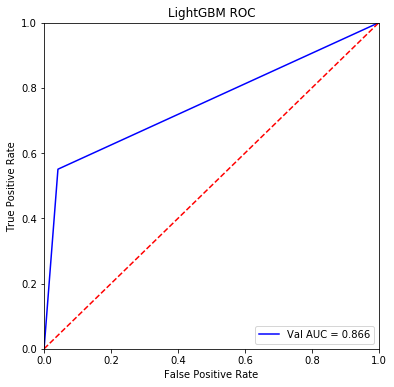

In [13]:
#print("LGBMClassifier模型训练集的准确率：%.3f" %lc.score(x_train, y_train))
#print("LGBMClassifier模型测试集的准确率：%.3f" %lc.score(x_test, y_test))
print("LGBMClassifier模型正确率：%.3f" %acc_lc)

#roc auc
#fpr, tpr, threshold = metrics.roc_curve(y_test, pred_lc)
#roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('LightGBM ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:
test_processed = test.copy()
le1=LabelEncoder()
le1.fit(test_processed['Gender'])
test_processed['Gender']=le1.transform(test_processed['Gender'])

le1.fit(test_processed['Region_Code'])
test_processed['Region_Code']=le1.transform(test_processed['Region_Code'])

le1.fit(test_processed['Channel_Code'])
test_processed['Channel_Code']=le1.transform(test_processed['Channel_Code'])

le1.fit(test_processed['Credit_Product'])
test_processed['Credit_Product']=le1.transform(test_processed['Credit_Product'])

le1.fit(test_processed['Is_Active'])
test_processed['Is_Active']=le1.transform(test_processed['Is_Active'])

le1.fit(test_processed['Occupation'])
test_processed['Occupation']=le1.transform(test_processed['Occupation'])

df_test1=test_processed.drop(['ID','Region_Code'],axis=1)
df_test1.head(20)


,Gender,Age,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,0,30,2,0,25,0,984562,1
1,1,51,3,1,62,0,1102184,1
2,1,39,3,0,38,0,737053,1
3,0,35,2,0,33,0,1839229,0
4,0,63,1,1,80,0,1627729,0
5,0,43,3,1,50,0,384382,1
6,0,41,3,2,21,1,748863,0
7,1,41,2,2,110,1,804382,1
8,0,56,3,2,104,0,583599,0
9,1,60,1,2,86,1,488209,1


In [15]:
df_test1_pred=lc.predict_proba(df_test1)[:,1]
df_IS_Lead=pd.DataFrame(df_test1_pred[:])
df_test1_pred

array([0.04761038, 0.06720126, 0.04554795, ..., 0.08245477, 0.11046631,
       0.09574269])

In [16]:
df_test1_pred.shape

(49145,)

In [17]:
df_IS_Lead[0][df_IS_Lead[0] > 0.5].count()

7971

In [18]:
#把预测结果输出到csv文件里
TOFILE = 1
if TOFILE == 1:
    
    df_IS_Lead.to_csv(outputFilePath,index=False)
    print('File written success!')
else:
    print('no outputfile!')

File written success!
